In [1]:
import pandas as pd
import numpy as np
import plotly.express as px 
from plotly.offline import iplot

from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from imblearn.combine import SMOTETomek

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

import warnings


# set Default
pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:,.2f}'.format
warnings.filterwarnings("ignore")
pd.options.mode.copy_on_write = "warn"

# Used Color
used_color = ["#ED1C24", "#FAF7F1", "#C0C0C0", "#F1ECDF", "#330072"]

In [2]:
def update_layout(
    title_font_size = 28,
    hover_font_size = 16,
    hover_bgcolor = '#111',
    showlegend = False
):
    fig.update_layout(
        showlegend = showlegend,
        title = {
            'font' : {
                'size' : title_font_size,
                'family' : '<b>poppins'
            }
        },
        
        hoverlabel = {
            'bgcolor' : hover_bgcolor,
            'font_size' : hover_font_size,
            'font_family' : 'poppins'
        }
    )

In [3]:
def count_viz_func(
    data_frame,
    column_name,
    title = 'Chart Title',
    title_font_size = 30,
    x_label = 'X',
    y_label = 'Y',
    showlegend = False,
    hover_template = 'None'
):
    value_counts = df[column_name].value_counts(normalize=1)*100
    
    fig = px.bar(
        data_frame = value_counts,
        x = value_counts.index,
        y = value_counts,
        color = value_counts.index,
        color_discrete_sequence = used_color,
        title = title,
        labels = {column_name:x_label, 'y': y_label},
        template = 'plotly_dark',
        text = value_counts.apply(lambda x: f'{x:.1f}%')
    )
    
    fig.update_layout(
        showlegend = showlegend,
        title = {
            'font' : {
                'size' : title_font_size,
                'family' : '<b>poppins'
            }
        },
        
        hoverlabel = {
            'bgcolor' : '#222',
            'font_size' : 16,
            'font_family' : 'poppins'
        }
    )
    
    fig.update_traces(
        textfont = {
            'size' : 18,
            'family' : 'consolas',
            'color' : '#222'
        },
        
        marker = dict(line=dict(color = '#222', width=1)),
        
        hovertemplate = hover_template
    )
    
    return fig

### __About Dataset__
* `Senior Citizen`: Indicates if the customer is 65 or older: Yes, No
* `Dependents`: Indicates if the customer lives with any dependents: Yes, No. Dependents could be children, parents, grandparents, etc
* `Tenure in Months`: Indicates the total amount of months that the customer has been with the company
* `Internet Service`: Indicates if the customer subscribes to Internet service with the company: No, DSL, Fiber Optic, Cable.
* `Contract`: Indicates the customer’s current contract type: Month-to-Month, One Year, Two Year.
* `Payment Method`: Indicates how the customer pays their bill: Bank Withdrawal, Credit Card, Mailed Check.
* `Monthly Charge`: Indicates the customer’s current total monthly charge for all their services from the company.
* `Total Charges`: Indicates the customer’s total charges, calculated to the end of the quarter specified above.
* `Churn: 1` = the customer left the company this quarter. 0 = the customer remained with the company

In [4]:
df = pd.read_csv('./WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [5]:
print(f'Number of Records: {df.shape[0]:.0f}')
print(f'Number of Features: {df.shape[1]}')

Number of Records: 7043
Number of Features: 21


In [6]:
df.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

### __Data Cleaning & Wrangling__

In [7]:
# Check For Null Values
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [8]:
# Duplicated Records
df.duplicated().sum()

0

In [9]:
# Check for Duplicated Customer ID
df['customerID'].duplicated().sum()

0

__Data almost clean and it's important that the `customerID` is unique for each customer because of it we need to remove the `customerID`__

In [10]:
df.drop(columns='customerID', inplace=True)

In [11]:
df.describe().T

count  mean   std   min   25%   50%   75%    max
SeniorCitizen  7,043.00  0.16  0.37  0.00  0.00  0.00  0.00   1.00
tenure         7,043.00 32.37 24.56  0.00  9.00 29.00 55.00  72.00
MonthlyCharges 7,043.00 64.76 30.09 18.25 35.50 70.35 89.85 118.75

### __Dig Deeper Into Each Column__

##### __Gender Column__

In [12]:
gender = df["gender"].value_counts(normalize=1)*100
gender

gender
Male     50.48
Female   49.52
Name: proportion, dtype: float64

In [13]:
fig = count_viz_func(
    df, 'gender', title= '<b>Gender Distributions', x_label='<b>Gender', y_label='<b>Frequency in PCT (%)', hover_template='Gender: %{x}<br>Frequency PCT (%): %{y:.0f}'
)

fig.update_traces(
    marker = dict(line= dict(color= '#FEFEFE', width=2))
)
iplot(fig)

In [14]:
len(df[df['Churn'] == 'Yes']) / len(df) * 100

26.536987079369588

##### __Senior Citizen Column__

In [15]:
f = df['Contract'] == 'Month-to-month'
df.loc[f, 'PaymentMethod']

0                Electronic check
2                    Mailed check
4                Electronic check
5                Electronic check
6         Credit card (automatic)
                  ...            
7033      Credit card (automatic)
7034      Credit card (automatic)
7035    Bank transfer (automatic)
7040             Electronic check
7041                 Mailed check
Name: PaymentMethod, Length: 3875, dtype: object

In [16]:
senior_citizen = df['SeniorCitizen'].value_counts(normalize=1)*100
senior_citizen.apply(lambda x: f'{x:.2f}%')

SeniorCitizen
0    83.79%
1    16.21%
Name: proportion, dtype: object

In [17]:
fig = px.bar(
    data_frame= senior_citizen,
    x= ['Greater Than 65' if i == 1 else 'Less Than 65' for i in senior_citizen.index],
    y= senior_citizen,
    color= ['Greater Than 65' if i == 1 else 'Less Than 65' for i in senior_citizen.index],
    color_discrete_sequence=used_color,
    title = '<b>Senior Citizen Distributions',
    labels = {'x': '<b>Is Senior Citizen', 'y': '<b>Frequency in PCT (%)'},
    template = 'plotly_dark',
    text = senior_citizen.apply(lambda x: f'{x:.1f}%')
)

update_layout()

fig.update_traces(
    textfont = {
        'size': 18,
        'family' : 'consolas',
        'color' : '#222'
    },
    
    marker = dict(line = dict(color = '#C0C0C0', width=2)),
    hovertemplate = 'Category: %{x}<br>Frequency in PCT (%): %{y:.0f}'
)
iplot(fig)

##### __Dependents Column__

In [18]:
dependents = (df['Dependents'].value_counts(normalize=1)*100).apply(lambda x: f'{x:.2f}%')
dependents

Dependents
No     70.04%
Yes    29.96%
Name: proportion, dtype: object

In [19]:
fig = count_viz_func(
    df, 'Dependents',
    title='<b>Dependents Distributions',
    x_label = '<b>Dependents',
    y_label = '<b>Frequency in PCT (%)',
    hover_template = 'Dependents: %{x}<br>Frequency in PCT (%): %{y:.0f}'
)

fig.update_traces(
    marker = dict(line=dict(color='#C0C0C0', width=2))
)
iplot(fig)

##### __Tenure Column__

In [20]:
fig = px.box(
    x=df['tenure'],
    template='plotly_dark',
    labels={'x': 'Tenure in Months'},
    title='<b>Tenure in Months',
    notched=True
)

fig.update_traces(
    marker = dict(color='red'),
    line = dict(width=3)
)

update_layout()
iplot(fig)

In [21]:
print(f'Tenure Skewness: {df["tenure"].skew():.4f}')

Tenure Skewness: 0.2395


### Insights based on Boxplot Statistic Tenure

**Insight Boxplot:**

1. **Variasi dalam Tenure:**
   - Tenure pelanggan bervariasi dari 0 hingga 72 bulan. Ini menunjukkan bahwa ada pelanggan yang baru saja bergabung (0 bulan) dan ada yang sudah lama (hingga 72 bulan).

2. **Distribusi Pelanggan:**
   - **Median (29 bulan):** Separuh dari pelanggan memiliki masa berlangganan kurang dari 29 bulan dan separuh lainnya lebih dari 29 bulan.
   - **Kuartil Pertama (Q1 - 9 bulan):** 25% dari pelanggan memiliki masa berlangganan 9 bulan atau kurang, menunjukkan bahwa sebagian besar pelanggan baru memiliki masa berlangganan pendek.
   - **Kuartil Ketiga (Q3 - 55 bulan):** 75% dari pelanggan memiliki masa berlangganan hingga 55 bulan atau kurang. Hanya 25% pelanggan yang memiliki masa berlangganan lebih dari itu.

3. **Pelanggan Baru vs. Pelanggan Lama:**
   - Adanya nilai minimum dan lower fence pada 0 bulan menunjukkan bahwa ada beberapa pelanggan yang sangat baru.
   - Nilai maksimum dan upper fence di 72 bulan menunjukkan bahwa beberapa pelanggan sangat setia dan telah bersama perusahaan untuk waktu yang lama.

4. **Keberagaman Pelanggan:**
   - Distribusi ini menunjukkan adanya keberagaman yang signifikan dalam masa berlangganan pelanggan, yang dapat mengindikasikan berbagai tingkat kepuasan dan loyalitas pelanggan.

### Insights dari Skewness Tenure

**Output Skewness:**
- **Tenure Skewness:** 0.2395

**Insight:**

1. **Distribusi Tenure yang Mendekati Simetris:**
   - Skewness (kemiringan) sebesar 0.2395 menunjukkan bahwa distribusi masa berlangganan (tenure) pelanggan hampir simetris, tetapi sedikit condong ke kanan.

2. **Impilikasi untuk Strategi Retensi:**
   - Skewness yang rendah menunjukkan bahwa sebagian besar pelanggan memiliki masa berlangganan yang tersebar cukup merata di sekitar median (29 bulan). Hal ini berarti tidak ada dominasi pelanggan baru atau pelanggan lama dalam data.
   - Sedikit condong ke kanan menunjukkan bahwa ada sedikit lebih banyak pelanggan dengan masa berlangganan yang lebih lama daripada yang baru, tetapi perbedaannya tidak signifikan.

3. **Kesempatan untuk Meningkatkan Loyalitas:**
   - Dengan distribusi yang mendekati simetris ini, perusahaan dapat mengembangkan strategi retensi yang lebih seimbang, berfokus pada menjaga pelanggan yang ada dan meningkatkan masa berlangganan pelanggan baru.

4. **Evaluasi Program Loyalitas:**
   - Melihat distribusi yang hampir simetris ini, program loyalitas bisa dievaluasi untuk melihat bagaimana program ini mempengaruhi pelanggan dengan berbagai lama berlangganan. Upaya bisa difokuskan untuk meningkatkan masa berlangganan pelanggan yang berada di bawah median.

##### __Phone Services Column__

In [22]:
phone_services = df['PhoneService'].value_counts()
phone_services.apply(lambda x: f'{x/sum(phone_services)*100:.2f}%')

PhoneService
Yes    90.32%
No      9.68%
Name: count, dtype: object

In [23]:
fig = px.pie(
    names= phone_services.index,
    values= phone_services,
    title= '<b>Phone Services Status Distribution',
    color_discrete_sequence=  used_color[0:3],
    hole= .6,
    template= 'plotly_dark'
)

# Func that give the Chart a custom format
update_layout(showlegend=True)

fig.update_traces(
    textinfo = 'label+percent',
    textfont = {
        'family' : 'consolas',
        'size' : 16
    },
    
    hovertemplate = 'Phone Services Status: %{label}<br>Frequency: %{value}',
    marker = dict(line=dict(color='#FFFFFF', width=2)),
    pull = [.090, .070]
)
iplot(fig)

##### __Internet Service Column__

In [24]:
inet_services = df['OnlineBackup'].value_counts()
inet_services.apply(lambda x: f'{x/sum(inet_services)*100:.2f}%')

OnlineBackup
No                     43.84%
Yes                    34.49%
No internet service    21.67%
Name: count, dtype: object

In [25]:
fig = px.pie(
    data_frame=inet_services,
    names=inet_services.index,
    values= inet_services,
    title= '<b>Internet Services Status Distribution',
    color_discrete_sequence= used_color[0:3],
    hole=.4
)

# Func that give the Chart a custom format
update_layout(showlegend=True)

fig.update_traces(
    textinfo = 'label+percent',
    textfont = {
        'size' : 16,
        'family' : 'consolas'
    },
    
    hovertemplate = 'Status: %{label}<br>Frequency: %{value:,.0f}',
    marker = dict(line = dict(color = '#222', width=2)),
    pull = [.0, .0, .09]
)
iplot(fig)

##### __Other Services__

In [26]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Choose Columns using `np.r_` method
target_cols = df.columns[np.r_[5:7, 8:14]]

fig = make_subplots(rows=4, cols=2, subplot_titles=target_cols)

r, c = 1, 0

for i in range(0, len(target_cols)):
    c += 1
    temp = df[target_cols[i]].value_counts()
    fig.add_trace(
        go.Bar(
            x= temp.index,
            y= temp/sum(temp)*100,
            text= temp.apply(lambda x: f'{x / sum(temp)*100:,.1f}%'),
            marker= dict(color=used_color)
        ),
        row=r,
        col=c
    )
    
    if c == 2:
        r += 1
        c = 0

fig.update_layout(height= 1700, title_text= '<b>Services Customer Distributions', template= 'plotly_dark')

update_layout(showlegend= False, hover_bgcolor='#F8F9FA', hover_font_size=14)

fig.update_traces(
    textfont= {
        'size': 14,
        'family': 'consolas',
        'color': '#111111'
    },
    
    marker= dict(line= dict(color= '#F8F9FA', width= 2.0)),
    hovertemplate= 'Services Status: %{x}<br>Customer Frequency: %{y:,.2f}%'
)
    
iplot(fig)

##### __Contract Column__

In [27]:
fig = count_viz_func(
    df,
    column_name= 'Contract',
    title= '<b>Contract Status Distributions',
    x_label= '<b>Contract',
    y_label= '<b>Frequency in PCT (%)',
    hover_template= 'Contract: %{x}<br>Frequency in PCT(%): y{y:,.0f}')

fig.update_traces(
    marker = dict(line= dict(color='#FEFEFE', width=2))
)
iplot(fig)

##### __Payment Method Column__

In [28]:
payment_method = df['PaymentMethod'].value_counts(normalize=1)*100
payment_method.apply(lambda x: f'{x: .2f}%')

PaymentMethod
Electronic check              33.58%
Mailed check                  22.89%
Bank transfer (automatic)     21.92%
Credit card (automatic)       21.61%
Name: proportion, dtype: object

In [29]:
fig = count_viz_func(
    df,
    column_name= 'PaymentMethod',
    title= '<b>Payment Method Distributions',
    x_label= '<b>Payment Method',
    y_label= '<b>Frequency in PCT(%)',
    hover_template= 'Payment Method: %{x}<br>Frequency in PCT(%): %{y:.2f}'
)

fig.update_traces(
    marker= dict(line= dict(color= '#FEFEFE', width= 2))
)
iplot(fig)

##### __Important Column: Monthly Charges Column__

In [30]:
df['MonthlyCharges'].describe()

count   7,043.00
mean       64.76
std        30.09
min        18.25
25%        35.50
50%        70.35
75%        89.85
max       118.75
Name: MonthlyCharges, dtype: float64

In [71]:
df["MonthlyCharges"].skew()

-0.22052443394398033

In [32]:
fig = px.box(
    x= df['MonthlyCharges'],
    template= 'plotly_dark',
    labels= {'x':'<b>Tenure in Months'},
    title= '<b>Monthly Charges Summary',
    notched= True
)

update_layout()

fig.update_traces(
    marker = dict(color='red'),
    line= dict(width=3)
)

iplot(fig)

Text(0, 0.5, 'Count')

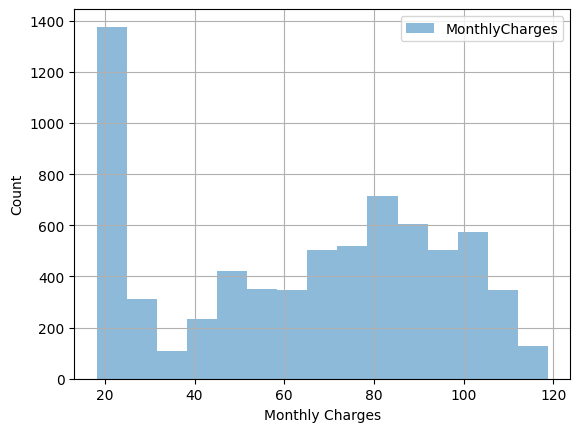

In [66]:
df['MonthlyCharges'].plot.hist(alpha= .5, bins=15, legend=True, grid= True)
plt.xlabel('Monthly Charges')
plt.ylabel('Count')

In [46]:
df[['MonthlyCharges', 'tenure']]

MonthlyCharges  tenure
0              29.85       1
1              56.95      34
2              53.85       2
3              42.30      45
4              70.70       2
...              ...     ...
7038           84.80      24
7039          103.20      72
7040           29.60      11
7041           74.40       4
7042          105.65      66

[7043 rows x 2 columns]